
# Bayesian Optimization
# Optimizing the SGD Learning Rate when Training a Neural Network

### Roger Garrida
### Akhil Lohia
### Daniel Velasquez

# Introduction 


Training a neural network can be a difficult task. In particular, due to the large number of hyperparameters that need to be tunned, e.g. number of layers, number of hidden units, batch size among other. In this project, we focus on one particular hyperparameter that influence directly the success of the learning procedure: The stochastic gradient descent **learning rate **. We use bayesian optimization to tune the learning rate and compare the results with a grid search.

In [22]:
#Required libraries
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
import math as mat
import scipy
from scipy.stats import norm
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns


## Gaussian Process

In [23]:
def gaussian_kernel(x1,x2,noise,length): #Generate the kernel (cov) of the Gaussian Process
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    kernel = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            kernel[i,j] = noise**2*mat.exp(-0.5*((x1[i]-x2[j])/length)**2)
    return kernel


In [24]:
def LLH_GP(x,y,m,noise,length, sf = 0): #Compute the likelihood of the data (add sf if consider noise)
    ker = gaussian_kernel(x,x, noise, length)
    ker = ker+np.diag([sf]*len(x))
    return 1/2*(mat.log(np.linalg.det(ker))+np.dot(np.dot(np.transpose(y-m),
                                                       np.linalg.inv(ker)),(y-m)))


In [43]:
def opt_hyparams(x,y): #Find the hyperparameters that optimize LLH without noise
    ini = np.array([0,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], params[1], params[2]),
                            ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = 0
    return m, noise, length, sf  

In [26]:
def opt_hyparams_noise(x,y): #Find the hyperparameters that optimize LLH with noise
    ini = np.array([0,1,1,1])
    opt = optimize.minimize(lambda params: LLH_GP(x, y, params[0], 
                                                  params[1], params[2], params[3]),ini)
    params = opt.x
    m = params[0]
    noise = abs(params[1])
    length = abs(params[2])
    sf = abs(params[3])
    return m, noise, length, sf

In [27]:
#Generates the mean and covariance of the posterior distribution in the given grid (xn) 
#from data (x,y) and the optimized parameters (mean->m, noise, length, noise in y -> sf)
def gp_posterior(x, y, xn, m, noise, length, sf = 0): 
    kxx = gaussian_kernel(x, x, noise = noise, length = length)
    kxxn = gaussian_kernel(x, xn, noise = noise, length = length)
    kxnx = gaussian_kernel(xn, x, noise = noise, length = length)
    kxnxn = gaussian_kernel(xn, xn, noise = noise, length = length)
    core = np.linalg.inv(kxx + np.diag([sf]*len(x)))
    En = np.dot(np.dot(kxnx, core), y)
    covn = kxnxn - np.dot(np.dot(kxnx, core), kxxn)  
    
    return En, covn

In [28]:
def data_posterior(x, E, cov):
    data = pd.DataFrame({'x': x})
    data['Mean'] = E
    data['StdDev'] = np.diag(cov)
    #Generate the 5 samples as multivariate normals with 0 mean and covariance sigma
    for i in range(5):
        data['y'+str(i)] = np.random.multivariate_normal(E, cov)
    return data


# Neural Network Architecture and Dataset

Our goal is to perform classification on the MNIST dataset. To do so, we build a neural network with one hidden layer and a fixed number of hidden units. We divide the dataset in training and test sample. We define a function that trains the network as a function of the learning rate and returns a measure of accuracy estimated using the test sample. The accuracy corresponds the number of correctly classified observations divided by the total number of observations within the test sample. 

In [29]:
#MNIST dataset:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [30]:
#placeholder:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

##Variables:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def neural_network(input, h_dim):
    W0 = weight_variable([784, h_dim])
    b0 = bias_variable([h_dim])
    h = tf.nn.relu(tf.matmul(input, W0) + b0)

    W = weight_variable([h_dim, 10])
    b = bias_variable([10])

    y = tf.nn.softmax(tf.matmul(h, W) + b)
    return y

#Network training:
def nn_train(learning_rate, h_dim, minibatch = 100):
    y = neural_network(x, h_dim)
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
    #train_step = tf.train.MomentumOptimizer(learning_rate, 0.5).minimize(cross_entropy)
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    n_samples = len(mnist.train.images)
    tf.global_variables_initializer().run()
    for _ in range(5000):
        batch_xs, batch_ys = mnist.train.next_batch(minibatch) #These variables are numpy arrays
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    return(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))



# Adquisition Function

We start with a gaussian prior on the hyperparameters. We define an adquisicion function that allows us to select a new learning rate to test. In particual we use *expected improvement*. With each new value, we train the network and use the output (the classification accuracy) to update the prior density. 


In [36]:
#Adquisition function

def acquisition_fun(x, y, xn, mean_vector, sigma_vector):
    x_best = x[np.argmax(y)]
    y_best = np.max(y)
    gamma = (mean_vector - y_best)/sigma_vector
    af = (mean_vector - y_best)* norm.cdf(gamma) - sigma_vector * norm.pdf(gamma)
    x_next = xn[np.argmax(af)]
    return x_next

# Algorithm


Initially, we assume we only observe 2 potential learning rates and their corresponding mean function. We implement an algorithm that, given some prior on the learning rate, at each iteration use the acquisition function to select a new candidate learning rate, trains the network and estimates the posterior density. The plots below show the evolution of the algorithm. 

/home/roger/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.


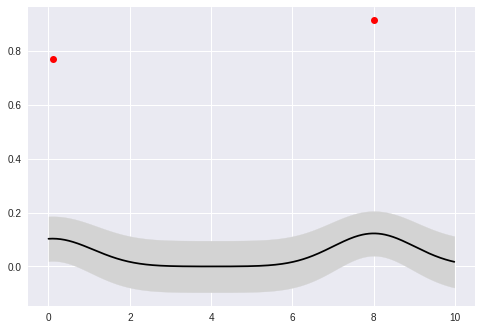

Initial Learning rates: [ 0.1  8. ]
Accuracy: [0.76789999, 0.91180003]


In [41]:

sess = tf.InteractiveSession()
h_dim = 20 # Fixed number of hidden dimensions
n = 500 # Number of point in the grid.
xn = np.arange(0,10,10/n)

l_rates = np.array([0.1,8]) # Initial leeaning rates
f = [nn_train(l, h_dim) for l in l_rates] #Accuracy

m, noise, length, sf = opt_hyparams_noise(l_rates,f)
E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
data = data_posterior(xn, E, cov)

#This plot shows the mean and variance with two initial observations: 
plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')
plt.show()

print ('Initial Learning rates:', l_rates)
print ('Accuracy:', f)

Now we perform 5 interations and observe the result:

In [ ]:
#If sf is used, we have to use opt_hyparams_noise, otherwise use opt_hyparams. 
n_iter = 5

for i in range(n_iter):    
    next_candidate = acquisition_fun(l_rates, f, xn, np.array(data['Mean']), np.array(data['StdDev']))
    l_rates = np.append(l_rates,next_candidate)
    f = np.append(f,nn_train(next_candidate, h_dim))
    E, cov = gp_posterior(l_rates, f, xn, m, noise, length, sf)
    data = data_posterior(xn, E, cov)

    try:
        m, noise, length, sf = opt_hyparams_noise(l_rates,f)
    except ValueError:
        m, noise, length, sf = m, noise, length, sf


plt.plot(data['x'],data['Mean'], color = 'black', label = 'Mean')
plt.plot(l_rates,f, 'ro', label = 'Obs')
plt.fill_between(data['x'], data['Mean']-data['StdDev'], data['Mean']+data['StdDev'],color = 'lightgrey')

plt.legend()
plt.show()


/home/roger/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: covariance is not positive-semidefinite.
